# Anzahl Teilnehmer beim Chat Duell

**Note**: At ~850MB of chat messages this script will use ~5GB of RAM. The calculations are single threaded and will take a few minutes (on an i7@4GHz).

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import datetime

In [2]:
#config
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'

In [3]:
columns = ['datetime', 'username', 'message']
data = pd.DataFrame({}, columns=columns)

exp = re.compile("\[(.+?)\] <(.+?)> (.+)?")

#read files
files = sorted(os.listdir(DATA_DIRECTORY))
for filename in files:
    if filename.endswith(".txt"):
        filepath = os.path.join(DATA_DIRECTORY, filename)
        dateStr = filename.rstrip('.txt')
        
        #read file
        openfile = open(filepath)
        rawData = openfile.read()
        openfile.close()

        #process each chat message
        splitRawData = rawData.split('\n')
        messages = []
        for line in splitRawData:
            match = exp.match(line)
            if match is not None:
                timeStr = match.group(1)
                datetimeStr = dateStr + ' ' + timeStr
                username = match.group(2)
                message = match.group(3)
                
                messages.append((datetimeStr, username, message))
        
        #create data frame and append data
        data = data.append(pd.DataFrame(messages, columns=columns))

#adjust data type
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

#create additional columns
data['date'] = data['datetime'].dt.date
data['time'] = data['datetime'].dt.time
data['weekday'] = data['datetime'].dt.dayofweek

#index
data = data.set_index(pd.to_datetime(data["datetime"], format='%Y-%m-%d %H:%M:%S'))

In [4]:
data.head()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2015-08-05 02:00:09,2015-08-05 02:00:09,tadloss,!sendeplan,2015-08-05,02:00:09,2
2015-08-05 02:00:09,2015-08-05 02:00:09,moobot,Angaben zum aktuellen Programm findet Ihr: Auf...,2015-08-05,02:00:09,2
2015-08-05 02:00:10,2015-08-05 02:00:10,dersendeplan,@tadloss (01:00) Blue Estate >> (02:30) Darkes...,2015-08-05,02:00:10,2
2015-08-05 02:00:17,2015-08-05 02:00:17,dedalos_stormbring,"@Gunvolf, Brav. Kappa",2015-08-05,02:00:17,2
2015-08-05 02:00:18,2015-08-05 02:00:18,unclesreefermadness,ist da nicht schmatzen gäng und ein kompliment,2015-08-05,02:00:18,2


In [5]:
data.tail()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2016-09-21 02:59:14,2016-09-21 02:59:14,niunOne,😖,2016-09-21,02:59:14,2
2016-09-21 02:59:21,2016-09-21 02:59:21,forearth,😯😦😣😠😈 Niemals! Gesichtskuchen,2016-09-21,02:59:21,2
2016-09-21 02:59:37,2016-09-21 02:59:37,SkyStraver,"@DMC05 bitte nicht q,q Du hast soviel mehr zu ...",2016-09-21,02:59:37,2
2016-09-21 02:59:57,2016-09-21 02:59:57,HipHopGuru,Den hat er Jahrelang verkauft,2016-09-21,02:59:57,2
2016-09-21 02:59:59,2016-09-21 02:59:59,niunOne,@DMC05 du machst immer so andeutungen und dann...,2016-09-21,02:59:59,2


In [6]:
dataFiltered = data

#filter messages by time
start = datetime.time(20, 15, 0)
end = datetime.time(22, 15, 0)
dataFiltered = dataFiltered.between_time(start, end)

#filter messages containing `!cd`
dataFiltered = dataFiltered[dataFiltered['message'].str.contains('!cd')]

#filter meassages by weekday
dataFiltered = dataFiltered[dataFiltered['weekday'] == 1]

#group messages by date
dataGrouped = dataFiltered.groupby('date')

#filter groups by count threshold
dataGrouped = dataGrouped.filter(lambda group: len(group) > 2000)

#group messages by date
dataGrouped = dataGrouped.groupby('date')

#count (unique) users
dataParticipants = dataGrouped.username.nunique()
dataParticipants

date
2015-12-01     8277
2015-12-08     7982
2015-12-15     5697
2015-12-22     6051
2016-01-12     7278
2016-01-19     6756
2016-02-02     6040
2016-02-09    11992
2016-02-16     5736
2016-02-23     6108
2016-03-01    11267
2016-03-08     5833
2016-03-15     5605
2016-06-28     4470
2016-07-12     3520
2016-07-19     2750
2016-07-26     3656
2016-08-02     3055
2016-08-09     3018
2016-08-23     3019
2016-08-30     2745
2016-09-13     2386
2016-09-20     1928
Name: username, dtype: int64

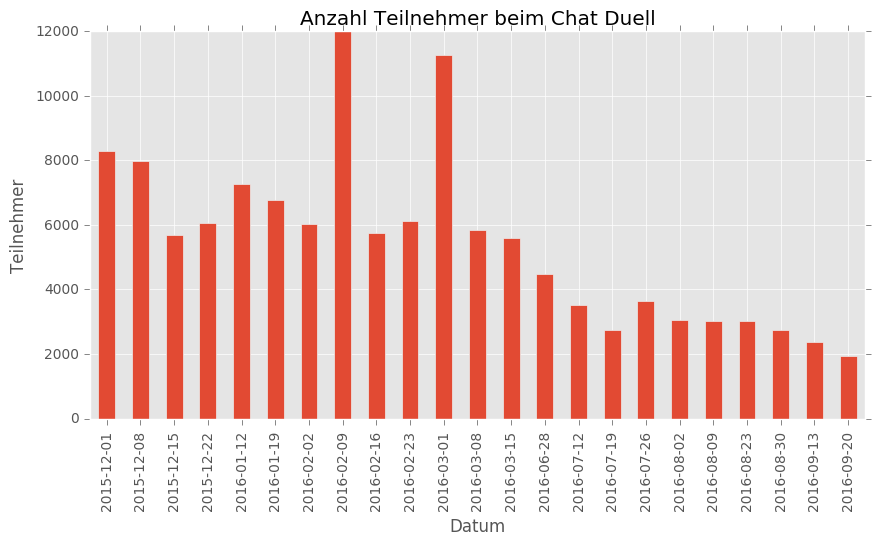

In [7]:
plot = dataParticipants.plot(kind='bar', figsize=(10, 5), title='Anzahl Teilnehmer beim Chat Duell')
plot.set_xlabel('Datum')
plot.set_ylabel('Teilnehmer')
plot